# Exercise 2

## Imports

In [1]:
import pyspark
from pyspark.sql import SparkSession, Window, Row, DataFrame
import pyspark.sql.types as T
import pyspark.sql.functions as F

## Initialize Spark

In [2]:
spark: SparkSession = (SparkSession
    .builder
    .appName('StructuredStreaming')
    .getOrCreate()
)

23/06/08 11:43:52 WARN Utils: Your hostname, martinho-MS-7B86 resolves to a loopback address: 127.0.1.1; using 192.168.1.67 instead (on interface enp34s0)
23/06/08 11:43:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 11:43:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Prepare the data

In [3]:
PORT = 9999

In [4]:
items = (spark
    .readStream
    .format('socket')
    .option('host', 'localhost')
    .option('port', PORT)
    .load()
    # Treat as CSV
    .select(F.split('value', ',', limit=2).alias('split_cols'))
    .select(F.col('split_cols')[0].alias('item'), F.to_timestamp(F.col('split_cols')[1]).alias('timestamp'))
)

23/06/08 11:44:01 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


In [ ]:
assert items.isStreaming

## DGIM

In [15]:
from typing import Iterator
from pyspark.sql.streaming.state import GroupState, GroupStateTimeout

import pandas as pd
from itertools import groupby

bucket_schema = (T.StructType()
    .add('bucket_size', T.IntegerType(), nullable=False)
    .add('end_timestamp', T.IntegerType(), nullable=False)
)
# The output Pandas Dataframe has columns bucket_size and end_timestamp
output_schema = bucket_schema
# The user-defined state is a tuple, containing an array where each element is another tuple containing the bucket_size and end_timestamp
state_schema = (T.StructType()
    .add('buckets', T.ArrayType(bucket_schema, containsNull=False), nullable=False)
)

def dgim_update(key: tuple, pdfs: Iterator[pd.DataFrame], state: GroupState, N: int) -> Iterator[pd.DataFrame]:
    
    # Initialize the state and get the old buckets state
    if not state.exists:
        state.update(([],))
    
    (buckets,) = state.get

    # Merge all Pandas Dataframes into a single Dataframe and sort it so we can know the absolute ordering of the new values
    pdf_aggregate = pd.concat(pdfs, ignore_index=True)
    pdf_aggregate.sort_values(by=['timestamp'], ascending=False, inplace=True)
    pdf_aggregate.reset_index(inplace=True)   # the index is scrambled after sorting, reset it to normal for use as the timestamps in the next loop
    # Take the real-time timestamp and replace with integer timestamp
    for end_timestamp, bit in pdf_aggregate['item'].items():
        if bit == '1':
            buckets.append((1, end_timestamp))

    maximum_bit_timestamp = pdf_aggregate.shape[0]

    # Update the timestamp of the old buckets (they are now older than the oldest in the current batch of bits)
    # Additionally, remove the buckets that are too old
    buckets = [(bucket_size, end_timestamp + maximum_bit_timestamp) for bucket_size, end_timestamp in buckets if end_timestamp + maximum_bit_timestamp <= N]

    new_buckets_merged = []
    # Keep track of the last merged bucket
    merged_buckets = []

    # Deal first with the smaller buckets
    buckets.sort(key=lambda t: t[0])
    for _, buckets_of_same_size in groupby(buckets, key=lambda t: t[0]):
        # Sort the buckets themselves by the end timestamp (earliest first, which are those with larger timestamp)
        buckets_of_same_size = sorted(buckets_of_same_size, key=lambda t: t[1], reverse=True)

        # If we merged buckets of the previous size, add them to this batch since they now belong to it
        if len(merged_buckets) > 0:
            buckets_of_same_size.extend(merged_buckets)
            merged_buckets.clear()

        while len(buckets_of_same_size) > 2:
            # Merge the earliest buckets
            (bitsum1, _) = buckets_of_same_size.pop(0)
            (bitsum2, end_timestamp2) = buckets_of_same_size.pop(0)
            merged_buckets.append((bitsum1 + bitsum2, end_timestamp2))

        new_buckets_merged.extend(buckets_of_same_size)

    # Leftover merged buckets
    if len(merged_buckets) > 0:
        new_buckets_merged.extend(merged_buckets)

    new_buckets_merged.sort(key=lambda t: t[1], reverse=True)

    state.update((new_buckets_merged,))

    yield pd.DataFrame(new_buckets_merged, columns=['bucket_size', 'end_timestamp'])

In [16]:
N = 1000    # N determines whether we should halve the counts for the last bucket (if end_timestamp with bucket_size surpasses N)
t = 10      # t determines the frequency with which the counts are computed
k = 900     # k determines the window size

Ns = f'{N} seconds'
ks = f'{k} seconds'
ts = f'{t} seconds'

outputter = (items
    # Disregard items that are too old
    .withWatermark('timestamp', '1 hour') 
            
    # Don't group
    .withColumn('dummy_key', F.lit(1))
    .groupby('dummy_key')
    
    # Keep and update DGIM buckets over time
    .applyInPandasWithState(
        lambda key, pdfs, state: dgim_update(key, pdfs, state, N),
        outputStructType=output_schema,
        stateStructType=state_schema,
        outputMode='append',
        timeoutConf=GroupStateTimeout.NoTimeout
    )

    # Add a column with the processing time, and then only consider the latest rows according to it
    # We have to do this because applyInPandasWithState does not support 'complete' mode
    .withColumn('processing_timestamp', F.current_timestamp())
    .groupby('processing_timestamp')
    .agg(F.collect_list(F.struct('bucket_size', 'end_timestamp')).alias('computed_buckets'))

    # Offer the buckets to be queried
    .writeStream
    .trigger(processingTime=ts)
    .outputMode('complete')
    .format('memory')
    .queryName('outputterMem')
    .start()
)

23/06/06 12:24:10 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-a6e805db-f79c-440f-85ae-50938db57b95. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/06/06 12:24:10 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [21]:
col_dgim_error_correction = F.when(F.first('end_timestamp') + F.first('bucket_size') > k, F.floor(F.first('bucket_size') / 2)).otherwise(0)

(spark.sql('SELECT * FROM outputterMem')
        .sort('processing_timestamp')
        .withColumn('dummy_key', F.lit(1))
        .groupby('dummy_key')
        .agg(F.explode(F.last('computed_buckets')).alias('computed_buckets_exploded'))
        .select(F.col('computed_buckets_exploded').bucket_size.alias('bucket_size'), F.col('computed_buckets_exploded').end_timestamp.alias('end_timestamp'))
        .filter(F.col('end_timestamp') <= k)
        .agg((F.sum('bucket_size') - col_dgim_error_correction).alias('total_ones'))
).collect()

[Row(total_ones=464)]

In [29]:
dgim_metrics = (spark.sql('SELECT * FROM outputterMem')
        .select('processing_timestamp', F.explode('computed_buckets').alias('computed_buckets_exploded'))
        .select('processing_timestamp', F.col('computed_buckets_exploded').bucket_size.alias('bucket_size'), F.col('computed_buckets_exploded').end_timestamp.alias('end_timestamp'))
        .groupby('processing_timestamp')
        .agg((F.sum('bucket_size') - col_dgim_error_correction).alias('total_ones'))
).collect()

Run this to quit the stream.

In [27]:
outputter.stop()

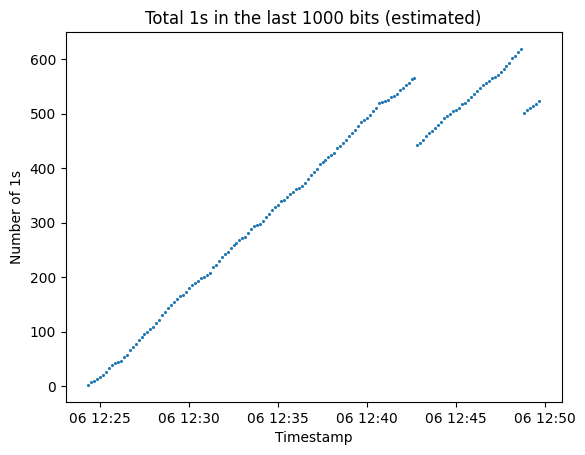

In [30]:
from plot_common import plot_ones_over_time

plot_ones_over_time(dgim_metrics, title_suffix=' (estimated)')

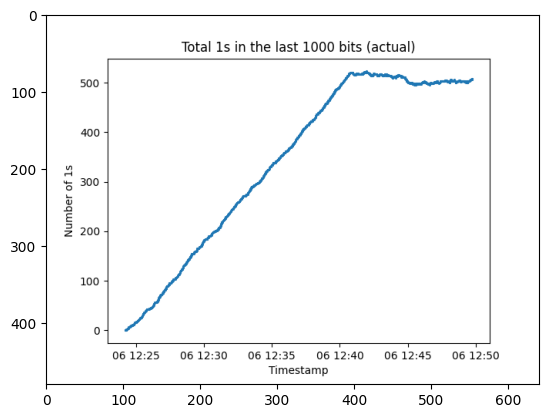

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow( mpimg.imread('results/dgim_ones.png') )
plt.show()

## Exponentially Decaying Windows

In [5]:
from typing import Iterator
from pyspark.sql.streaming.state import GroupState, GroupStateTimeout

import pandas as pd

counts_schema = (T.StructType()
    .add('item', T.StringType())
    .add('count', T.DoubleType())
)
# The output Pandas Dataframe has columns item and count
output_schema = counts_schema
# The user-defined state is a tuple, containing a map of item counts
state_schema = (T.StructType()
    .add('counts', T.MapType(T.StringType(), T.DoubleType(), valueContainsNull=False), nullable=False)
)

def exponential_count_update(key: tuple, pdfs: Iterator[pd.DataFrame], state: GroupState, c: float, score_threshold: float) -> Iterator[pd.DataFrame]:
    
    # Initialize the state and get the old counts state
    if not state.exists:
        state.update(({},))
    
    (counts,) = state.get

    # Merge all Pandas Dataframes into a single Dataframe and sort it so we can know the absolute ordering of the new values
    # Also reset the index so that we can get proper ordering
    pdf_aggregate = pd.concat(pdfs, ignore_index=True)
    pdf_aggregate.sort_values(by=['timestamp'], ascending=False, inplace=True)
    
    time_elaped = pdf_aggregate.shape[0]
    pdf_aggregate['time_step'] = range(time_elaped)

    # Update old counts (make them older)
    old_decay = ((1 - c)**time_elaped)
    counts = {item: count * old_decay for item, count in counts.items() if count * old_decay >= score_threshold}

    # Add new counts
    for item, group in pdf_aggregate.groupby(by='item'):
        counts.setdefault(item, 0)
        counts[item] += float(((1 - c)**group['time_step']).sum())

    state.update((counts,))

    counts_items = counts.items()
    yield pd.DataFrame({'item': [i for i, _ in counts_items], 'count': [c for _, c in counts_items]}, columns=['item', 'count'])

In [32]:
c = 1e-6
score_threshold = 1 / 2

outputter = (items
    # Disregard items that are too old
    .withWatermark('timestamp', '1 hour') 
            
    # Don't group
    .withColumn('dummy_key', F.lit(1))
    .groupby('dummy_key')
    
    # Keep and update exponentially decaying counts over time
    .applyInPandasWithState(
        lambda key, pdfs, state: exponential_count_update(key, pdfs, state, c, score_threshold),
        outputStructType=output_schema,
        stateStructType=state_schema,
        outputMode='append',
        timeoutConf=GroupStateTimeout.NoTimeout
    )

    # Add a column with the processing time, and then only consider the latest rows according to it
    # We have to do this because applyInPandasWithState does not support 'complete' mode
    .withColumn('processing_timestamp', F.current_timestamp())
    .groupby('processing_timestamp')
    .agg(F.collect_list(F.struct('item', 'count')).alias('computed_counts'))

    # Offer the counts to be queried
    .writeStream
    .trigger(processingTime='1 seconds')
    .outputMode('complete')
    .format('memory')
    .queryName('outputterMem')
    .start()
)

23/06/08 12:28:39 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-a417a385-0ce1-4f58-94db-c9afbddade7a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/06/08 12:28:39 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [19]:
(spark.sql('SELECT * FROM outputterMem')
        .sort('processing_timestamp')
        .withColumn('dummy_key', F.lit(1))
        .groupby('dummy_key')
        .agg(F.explode(F.last('computed_counts')).alias('computed_counts_exploded'))
        .select(F.col('computed_counts_exploded').item.alias('item'), F.col('computed_counts_exploded').count.alias('count'))
        .sort('count', ascending=True)
).tail(5)

[]

23/06/08 12:00:37 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 5108 milliseconds
23/06/08 12:00:42 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 4790 milliseconds
23/06/08 12:00:47 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 4902 milliseconds
23/06/08 12:00:52 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 4647 milliseconds
23/06/08 12:00:57 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 4683 milliseconds
23/06/08 12:01:02 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 4616 milliseconds
23/06/08 12:01:06 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger in

In [34]:
edw_metrics = (spark.sql('SELECT * FROM outputterMem')
        .select('processing_timestamp', F.explode('computed_counts').alias('computed_counts_exploded'))
        .select('processing_timestamp', F.col('computed_counts_exploded').item.alias('item'), F.col('computed_counts_exploded').count.alias('count'))
        .sort('count', ascending=False)
        .groupby('processing_timestamp')
        .agg(F.slice(F.collect_list('item'), 1, 5).alias('top_5'))
).collect()

23/06/08 12:33:46 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 5031 milliseconds


In [36]:
outputter.stop()

23/06/08 12:33:52 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 61, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@15369b6] is aborting.
23/06/08 12:33:52 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 61, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@15369b6] aborted.
23/06/08 12:33:52 WARN Shell: Interrupted while joining on: Thread[Thread-964887,5,main]
java.lang.InterruptedException
	at java.base/java.lang.Object.wait(Native Method)
	at java.base/java.lang.Thread.join(Thread.java:1300)
	at java.base/java.lang.Thread.join(Thread.java:1375)
	at org.apache.hadoop.util.Shell.joinThread(Shell.java:1042)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:1002)
	at org.apache.hadoop.util.Shell.run(Shell.java:900)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1212)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1306)
	at o

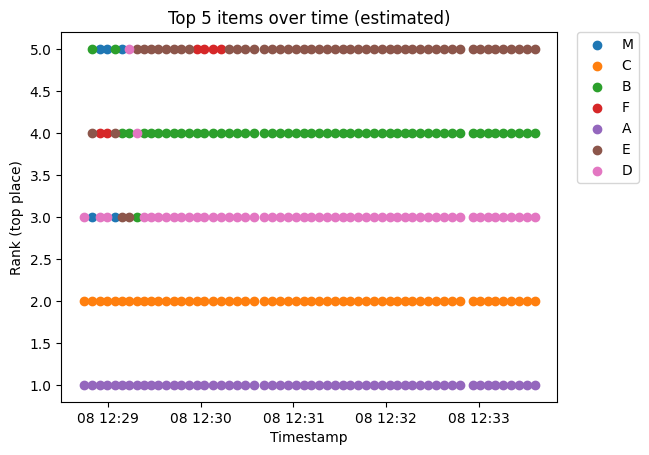

23/06/08 12:33:51 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 1000 milliseconds, but spent 5064 milliseconds


In [35]:
from plot_common import plot_top_5_over_time

plot_top_5_over_time(edw_metrics, title_suffix=' (estimated)')

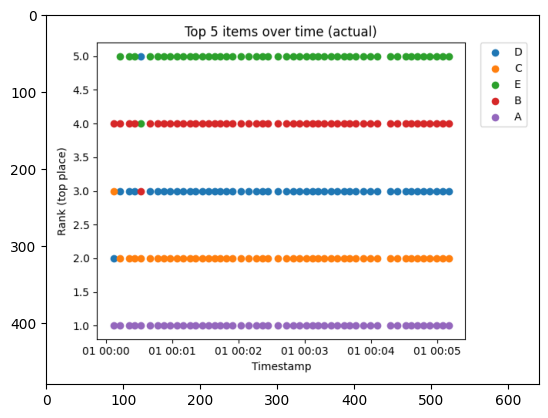

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow( mpimg.imread('results/edw_top.png') )
plt.show()